In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SelectFromModel, RFECV, RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import model_selection
import pathlib
import scipy
import random

sns.set()
from cellesce import Cellesce

VARIABLES = ["Conc /uM", "Date", "Drug"]
SAVE_FIG = True
SAVE_CSV = True

# data_folder = "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_all"
# data_folder = "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_objects"

# pd.read_csv("analysed/_2019_cellesce_unet_splineparameters_aligned/raw/projection_XY/Secondary.csv")

kwargs = {
    "data_folder": "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_all",
    "nuclei_path": "object_filteredNuclei.csv",
}
kwargs = {
    "data_folder": "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_objects",
    "nuclei_path": "Secondary.csv",
}


kwargs = {
    "data_folder": "analysed/_2019_cellesce_unet_splineparameters_aligned/raw/projection_XY/",
    "nuclei_path": "Secondary.csv",
}


kwargs = {
    "data_folder": "analysed/_2019_cellesce_unet_splineparameters_aligned/raw/projection_XY/",
    "nuclei_path": "Secondary.csv",
}

kwargs_cellprofiler = {
    "data_folder": "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_objects",
    "nuclei_path": "object_filteredNuclei.csv",
}


# kwargs_splinedist = {
#     "data_folder": "analysed/cellprofiler",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }


kwargs_splinedist = {
    "data_folder": "analysed/cellesce_splinedist_controlpoints",
    "nuclei_path": "Secondary.csv",
}

kwargs_splinedist = {
    "data_folder": "old_results/control_points",
    "nuclei_path": "objects_FilteredNuclei.csv",
}

# kwargs_cellprofiler = {
#     "data_folder": "analysed/cellprofiler/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }


kwargs_cellprofiler = {
    "data_folder": "old_results/analysed/cellprofiler/splinedist",
    "nuclei_path": "objects_FilteredNuclei.csv",
}


In [2]:
# kwargs_cellprofiler = {
#     "data_folder": "analysed/cellprofiler/splinedist_32",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }

kwargs = kwargs_splinedist
kwargs = kwargs_cellprofiler


def save_csv(df, path):
    df.to_csv(metadata(path))
    return df


results_folder = f"results/merged"
pathlib.Path(results_folder).mkdir(parents=True, exist_ok=True)


def metadata(x):
    path = pathlib.Path(results_folder, x)
    print(path)
    return path



In [3]:
from sklearn.metrics.pairwise import euclidean_distances
from cellesce import Cellesce

df_splinedist = (
    Cellesce(**kwargs_splinedist)
    .get_data()
    .cellesce.preprocess()
    .cellesce.clean()
    .assign(Features="Spline")
    .set_index(["Features"], append=True)
)

In [4]:
# distogram.flatten()
# distogram = sklearn.metrics.pairwise.euclidean_distances(df.iloc[[0]].T)
df_sorted = df_splinedist.reindex(
    np.array(sorted(df_splinedist.columns.astype(np.int))).astype(np.str), axis=1
)
df_dist = df_sorted.apply(
    lambda x: euclidean_distances(np.array(x).reshape(-1, 1)).flatten(),
    axis=1,
    result_type="expand",
)

/tmp/ipykernel_1787572/2461859960.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array(sorted(df_splinedist.columns.astype(np.int))).astype(np.str), axis=1
/tmp/ipykernel_1787572/2461859960.py:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.h

In [6]:
# euclid = euclidean_distances(np.array(df_sorted.iloc[0]).reshape(-1, 1))

# from sklearn.manifold import MDS 

# mds = MDS(dissimilarity='precomputed').fit(euclid)

# mds.transform(euclid)


/home/ctr26/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


results/merged/pca.pdf


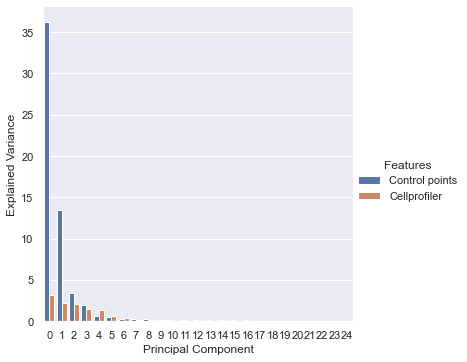

In [7]:

df_dist = df_sorted.apply(
    lambda x: euclidean_distances(np.array([x[0::2], x[1::2]]).T).flatten(),
    axis=1,
    result_type="expand",
)

df_dist = (
    df_sorted.apply(
        lambda x: np.tril(euclidean_distances(np.array([x[0::2], x[1::2]]).T))
        .flatten()
        .flatten(),
        axis=1,
        result_type="expand",
    )
    .replace(0, np.nan)
    .dropna(axis=1)
)
df_dist.columns = df_dist.columns.astype(str)
# df_dist = (df_sorted
#             .apply(lambda x: euclidean_distances(np.array([x[0::2],x[1::2]]).T,[[0,0]])
#             .flatten(),axis=1,result_type="expand"))
df_splinedist = df_dist
rows, features = df_splinedist.shape
df_cellprofiler = (
    Cellesce(**kwargs_cellprofiler)
    .get_data()
    .cellesce.preprocess()
    .cellesce.clean()
    .assign(Features="Cellprofiler")
    .set_index(["Features"], append=True)
    # .sample(32,axis=1,random_state=42)
)
df_cellprofiler.columns = df_cellprofiler.columns.str.replace("AreaShape_", "")
df = pd.concat([df_cellprofiler, df_splinedist])


pca_spline = PCA(n_components=0.99).fit(df_splinedist)
pca_cellprofiler = PCA(n_components=0.99).fit(df_cellprofiler)

pd.DataFrame(pca_spline.explained_variance_, columns=["Explained Variance"]).assign(
    **{
        "Features": "Control points",
        "Principal Component":
            np.arange(0, len(pca_spline.explained_variance_)),
    }
)


exp_var = pd.concat(
    [
        pd.DataFrame(
            pca_spline.explained_variance_, columns=["Explained Variance"]
        ).assign(
            **{
                "Features": "Control points",
                "Principal Component": np.arange(
                    0, len(pca_spline.explained_variance_)
                ),
            }
        ),
        pd.DataFrame(
            pca_cellprofiler.explained_variance_, columns=["Explained Variance"]
        ).assign(
            **{
                "Features": "Cellprofiler",
                "Principal Component": np.arange(
                    0, len(pca_cellprofiler.explained_variance_)
                ),
            }
        ),
    ]
)

pca_component = pd.concat(
    [
        pd.DataFrame(pca_spline.components_, columns=df_splinedist.columns).assign(
            **{
                "Features": "Control points",
                "Principal Component": np.arange(
                    0, len(pca_spline.explained_variance_)
                ),
            }
        ),
        pd.DataFrame(
            pca_cellprofiler.components_, columns=df_cellprofiler.columns
        ).assign(
            **{
                "Features": "Cellprofiler",
                "Principal Component": np.arange(
                    0, len(pca_cellprofiler.explained_variance_)
                ),
            }
        ),
    ]
).set_index(["Features", "Principal Component"])


sns.catplot(
    x="Principal Component",
    hue="Features",
    y="Explained Variance",
    data=exp_var,
    legend_out=True,
    kind="bar",
)
plt.savefig(metadata("pca.pdf"), bbox_inches="tight")
plt.show()


In [8]:
component_melt = pd.melt(
    pca_component,
    var_name="Feature",
    value_name="Component Magnitude",
    ignore_index=False,
).set_index(["Feature"], append=True)
plt.show()

important_features = (
    component_melt.transform(abs)
    .reset_index()
    .sort_values("Component Magnitude", ascending=False)
    .drop_duplicates(["Features", "Principal Component"])
    .sort_values("Principal Component")
)
plt.show()

In [9]:
# sns.catplot(
#     x="Principal Component",
#     y="Feature",
#     data=important_features.reset_index(),
#     col="Features",
#     sharey=False,
# )
# plt.show()

In [10]:

# sns.catplot(
#     col="Principal Component",
#     y="Feature",
#     x="Component Magnitude",
#     sharey=False,
#     data=component_melt.reset_index(),
#     row="Features",
#     height=12,
# )
# plt.show()

Organoids: 515 Nuclei: 37235


/home/ctr26/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


results/merged/fingerprints.pdf


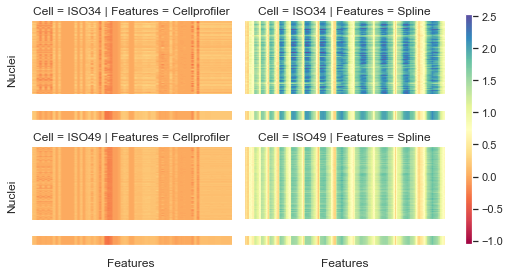

In [11]:
# df = df.iloc[:,random.sample(range(0, features), 32)]

print(
    f'Organoids: {df.cellesce.grouped_median("ObjectNumber").cellesce.simple_counts()}',
    f"Nuclei: {df.cellesce.simple_counts()}",
)

upper = np.nanmean(df.values.flatten()) + 2 * np.nanstd(df.values.flatten())
lower = np.nanmean(df.values.flatten()) - 2 * np.nanstd(df.values.flatten())


def df_to_fingerprints_facet(*args, **kwargs):

    data = kwargs.pop("data")
    data = data.drop([*args[2:]], 1)

    image = data.dropna(axis=1, how="all")

    rows, cols = image.shape
    median_height = 0.1
    gap_height = 0.15
    # median_rows = int(rows*median_height/100)
    image_rows_percent = 1 - (gap_height + median_height)
    one_percent = rows / image_rows_percent
    # print(one_percent,rows)
    gap_rows = int(gap_height * one_percent)
    median_rows = int(median_height * one_percent)

    # median_rows,gaps_rows=(rows,rows)
    finger_print = image.median(axis=0)

    finger_print_image = np.matlib.repmat(finger_print.values, median_rows, 1)
    all_data = np.vstack([image, np.full([gap_rows, cols], np.nan), finger_print_image])

    # fig,ax = plt.subplots(figsize=(5,3), dpi=150)
    # fig, ax = plt.figure(figsize=(5,3), dpi=150)
    plt.imshow(all_data, vmin=lower, vmax=upper, cmap="Spectral")
    # sns.heatmap(all_data,vmin=lower, vmax=upper, cmap="Spectral",interpolation='nearest')
    fig, ax = (plt.gcf(), plt.gca())
    ax.set(adjustable="box", aspect="auto", autoscale_on=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_facecolor("white")
    ax.grid(False)
    # fig.add_subplot(2,2,1)


sns.set()
g = sns.FacetGrid(
    df.reset_index(level=["Cell", "Features"]),
    col="Features",
    row="Cell",
    height=2,
    aspect=1.61,
    sharey=False,
    sharex=False,
)
cax = g.fig.add_axes([1.015, 0.13, 0.015, 0.8])
g.map_dataframe(
    df_to_fingerprints_facet,
    "Features",
    "Nuclei",
    "Features",
    "Cell",
    cmap="Spectral",
    cbar=True,
    vmax=upper,
    vmin=lower,
)
plt.colorbar(cax=cax)
plt.savefig(metadata("fingerprints.pdf"), bbox_inches="tight")
plt.show()

In [12]:
feature_importance = df.groupby(level="Features").apply(
    lambda df: df.cellesce.grouped_median()
    .dropna(axis=1)
    .cellesce.feature_importances(variable="Cell")
)


              precision    recall  f1-score   support

       ISO34       0.81      0.76      0.79        34
       ISO49       0.89      0.91      0.90        69

    accuracy                           0.86       103
   macro avg       0.85      0.84      0.84       103
weighted avg       0.86      0.86      0.86       103

0.6880138468195587
              precision    recall  f1-score   support

       ISO34       0.82      0.73      0.77        37
       ISO49       0.86      0.91      0.88        65

    accuracy                           0.84       102
   macro avg       0.84      0.82      0.83       102
weighted avg       0.84      0.84      0.84       102

0.6526181353767562


Spline: 0.3427668717665264 Cellprofiler: 0.25776150625639477
Spline: 8.549867592624446e-14 Cellprofiler: 0.11631357985245201
              precision    recall  f1-score   support

       ISO34       0.81      0.76      0.78        33
       ISO49       0.89      0.91      0.90        70

    accuracy                           0.86       103
   macro avg       0.85      0.84      0.84       103
weighted avg       0.86      0.86      0.86       103

0.6827980642322922
              precision    recall  f1-score   support

       ISO34       0.78      0.86      0.82        29
       ISO49       0.94      0.90      0.92        73

    accuracy                           0.89       102
   macro avg       0.86      0.88      0.87       102
weighted avg       0.90      0.89      0.89       102

0.7430142006413193
results/merged/importance_median_control_points.csv


/home/ctr26/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:3805: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


results/merged/importance_median_control_points.pdf


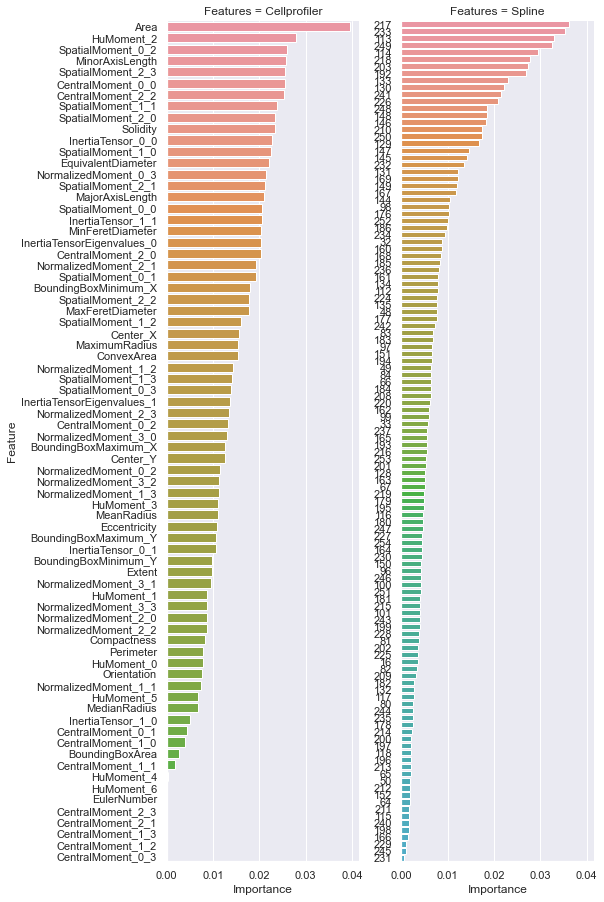

In [13]:

# sample = -1

spline_importances = feature_importance.xs("Spline", level="Features")["Importance"]

cellprofiler_importances = feature_importance.xs("Cellprofiler", level="Features")["Importance"]

spline_H = scipy.stats.entropy(spline_importances,qk=np.ones_like(spline_importances)/len(spline_importances))

cellprofiler_H = scipy.stats.entropy(cellprofiler_importances,qk=np.ones_like(cellprofiler_importances)/len(cellprofiler_importances));cellprofiler_H

# scipy.stats.ks_2samp(cellprofiler_importances,np.ones_like(cellprofiler_importances)/len(cellprofiler_importances))

# scipy.stats.ks_2samp(spline_importances,np.ones_like(spline_importances)/len(spline_importances))

spline_test = scipy.stats.normaltest(feature_importance.xs("Spline", level="Features"))
cellprofiler_test = scipy.stats.normaltest(
    feature_importance.xs("Cellprofiler", level="Features")
)
print(f"Spline: {spline_H} Cellprofiler: {cellprofiler_H}")
print(f"Spline: {spline_test.pvalue[0]} Cellprofiler: {cellprofiler_test.pvalue[0]}")


sns.catplot(
    y="Feature",
    x="Importance",
    col="Features",
    sharey=False,
    kind="bar",
    aspect=1 / 3,
    height=12.5,
    data=(
        (
            df.groupby(level="Features").apply(
                lambda df: df.cellesce.grouped_median()
                .dropna(axis=1)
                .cellesce.feature_importances(variable="Cell")
            )
        )
        .reset_index()
        .pipe(save_csv, "importance_median_control_points.csv")
    ),
)

# plt.tight_layout()
plt.savefig(metadata("importance_median_control_points.pdf"))
plt.show()

In [14]:
# sns.barplot(
#     y="Feature", x="Cumulative Importance",
#     data=df.cellesce.feature_importances(variable="Cell").reset_index()
# )
# plt.tight_layout()



In [15]:
#     data=(
#         pd.concat(
#         [(
#             df.cellesce.grouped_median("ObjectNumber")
#             .cellesce.get_score_report("Cell")
#             .assign(**{"Population type": "Organoid"})
#             .set_index("Metric")
#             .loc[['f1-score', 'recall','precision']]
#             .reset_index()
#             .assign(Fold=fold)
#             .pipe(save_csv,"Cell_predictions_organoid.csv")
#             )
#         for fold in range(5)]
#     )),
# data =  pd.concat([
#         (pd.concat(
#         [
#             (
#                 (df.groupby(level="Features")
#                  .apply(lambda df:
#                     df.dropna(axis=1)
#                     .cellesce.get_score_report(variable="Cell")))
#                 .assign(**{"Population type": "Nuclei"})
#             ),
#             (
#                 (df.groupby(level="Features")
#                  .apply(lambda df:
#                     df.cellesce.grouped_median().dropna(axis=1)
#                     .cellesce.get_score_report(variable="Cell")))
#                 .assign(**{"Population type": "Organoid"})
#             ),
#         ])
#         .reset_index()
#         .set_index("Metric")
#         .loc[['f1-score', 'recall','precision']])
#         .reset_index()
#         .assign(Fold=fold) for fold in range(5)
#         ]).pipe(save_csv,"Cell_predictions_image_vs_nuclei.csv")

In [16]:
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")
data_list = []
for fold in tqdm(range(5)):
    print(f"Fold {fold}")
    df_temp = (
        pd.concat(
            [
                (
                    (
                        df.groupby(level="Features").apply(
                            lambda df: df.dropna(axis=1).cellesce.get_score_report(
                                variable="Cell"
                            )
                        )
                    ).assign(**{"Population type": "Nuclei"})
                ),
                (
                    (
                        df.groupby(level="Features").apply(
                            lambda df: df.cellesce.grouped_median()
                            .dropna(axis=1)
                            .cellesce.get_score_report(variable="Cell")
                        )
                    ).assign(**{"Population type": "Organoid"})
                ),
            ]
        )
        .reset_index()
        .set_index("Metric")
        .loc[["f1-score", "recall", "precision"]]
        .reset_index()
        .assign(Fold=fold)
    )
    data_list.append(df_temp)

data = pd.concat(data_list).pipe(save_csv, "Cell_predictions_image_vs_nuclei.csv")

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 0


 20%|██        | 1/5 [02:54<11:39, 174.88s/it]

Fold 1


 40%|████      | 2/5 [05:25<08:02, 160.76s/it]

Fold 2


 60%|██████    | 3/5 [07:54<05:10, 155.30s/it]

Fold 3


 80%|████████  | 4/5 [10:33<02:36, 156.79s/it]

Fold 4


100%|██████████| 5/5 [13:04<00:00, 156.86s/it]

results/merged/Cell_predictions_image_vs_nuclei.csv


results/merged/Cell_predictions_image_vs_nuclei.pdf


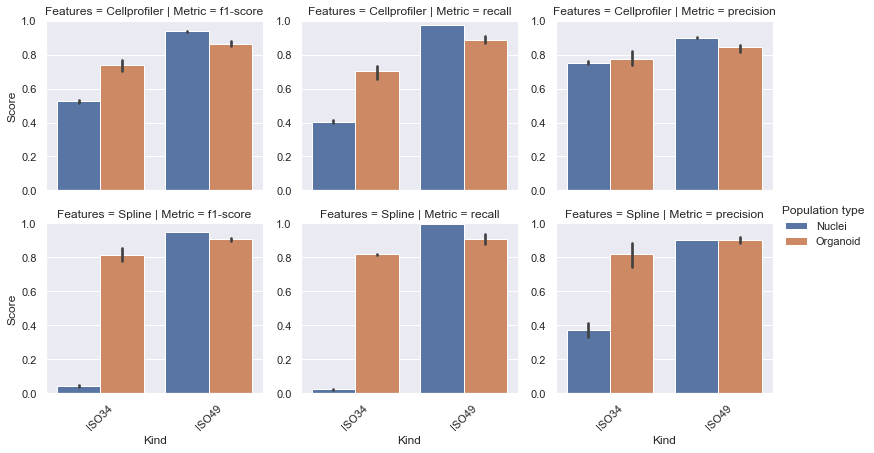

results/merged/Cell_predictions_organoid.pdf


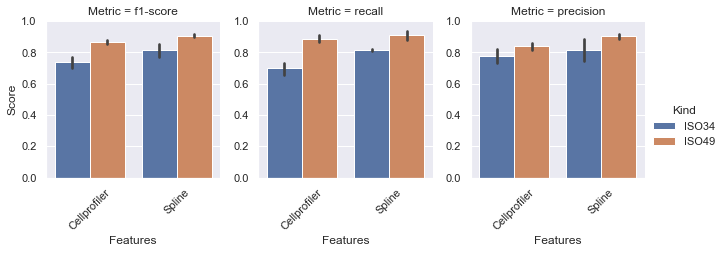

In [17]:
plot = (
    sns.catplot(
        aspect=1.2,
        height=3,
        x="Kind",
        y="Score",
        col="Metric",
        row="Features",
        # ci=None,
        hue="Population type",
        data=data,
        sharey=False,
        kind="bar",
    )
    .set_xticklabels(rotation=45)
    .set(ylim=(0, 1))
)
# plt.tight_layout()
if SAVE_FIG:
    plt.savefig(metadata("Cell_predictions_image_vs_nuclei.pdf"))
plt.show()

plot = (
    sns.catplot(
        aspect=1,
        height=3,
        x="Features",
        y="Score",
        col="Metric",
        hue="Kind",
        # ci=None,
        data=data.set_index("Population type").loc["Organoid"],
        sharey=False,
        kind="bar",
    )
    .set_xticklabels(rotation=45)
    .set(ylim=(0, 1))
)
# plt.tight_layout()
if SAVE_FIG:
    plt.savefig(metadata("Cell_predictions_organoid.pdf"), bbox_inches="tight")
plt.show()


In [18]:


# df_temp = ((df.groupby(level="Features")
#                 .apply(lambda df:
#                     df.cellesce.grouped_median().dropna(axis=1)
#                     .cellesce.get_score_report(variable="Cell")))
#                 .assign(**{"Population type": "Organoid"})
#         .reset_index()
#         .set_index("Metric")
#         .loc[['f1-score', 'recall','precision']]
#         .reset_index())
# data_list.append(df_temp)
